In [8]:
import pandas as pd
import arviz as az
import numpy as np
import math
import timedelta
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_pickle('events.pkl')
df.head()

,eventInfo,eventType,eventDescription,picks,amplitudes
0,{'publicID': 'smi:nakamura81/event/00001'},earthquake,unclassified deep moonquake,"[{'stationCode': 'S11', 'networkCode': 'XA', '...",[{'publicID': 'smi:nakamura81/amplitude/S11/00...
1,{'publicID': 'smi:nakamura81/event/00002'},meteorite,meteoroid,"[{'stationCode': 'S11', 'networkCode': 'XA', '...",[{'publicID': 'smi:nakamura81/amplitude/S11/00...
2,{'publicID': 'smi:nakamura81/event/00003'},earthquake,deep moonquake,"[{'stationCode': 'S11', 'networkCode': 'XA', '...",[{'publicID': 'smi:nakamura81/amplitude/S11/00...
3,{'publicID': 'smi:nakamura81/event/00004'},meteorite,meteoroid,"[{'stationCode': 'S11', 'networkCode': 'XA', '...",[{'publicID': 'smi:nakamura81/amplitude/S11/00...
4,{'publicID': 'smi:nakamura81/event/00005'},meteorite,meteoroid,"[{'stationCode': 'S11', 'networkCode': 'XA', '...",[{'publicID': 'smi:nakamura81/amplitude/S11/00...


In [3]:
# Select only earthquake events
quakesOnly = df.loc[df['eventDescription'] == 'deep moonquake']
#quakesOnly = quakesOnly.reset_index(drop=True)
quakesOnly

,eventInfo,eventType,eventDescription,picks,amplitudes
2,{'publicID': 'smi:nakamura81/event/00003'},earthquake,deep moonquake,"[{'stationCode': 'S11', 'networkCode': 'XA', '...",[{'publicID': 'smi:nakamura81/amplitude/S11/00...
8,{'publicID': 'smi:nakamura81/event/00009'},earthquake,deep moonquake,"[{'stationCode': 'S11', 'networkCode': 'XA', '...",[{'publicID': 'smi:nakamura81/amplitude/S11/00...
12,{'publicID': 'smi:nakamura81/event/00013'},earthquake,deep moonquake,"[{'stationCode': 'S12', 'networkCode': 'XA', '...",[{'publicID': 'smi:nakamura81/amplitude/S12/00...
14,{'publicID': 'smi:nakamura81/event/00015'},earthquake,deep moonquake,"[{'stationCode': 'S12', 'networkCode': 'XA', '...",[{'publicID': 'smi:nakamura81/amplitude/S12/00...
15,{'publicID': 'smi:nakamura81/event/00016'},earthquake,deep moonquake,"[{'stationCode': 'S12', 'networkCode': 'XA', '...",[{'publicID': 'smi:nakamura81/amplitude/S12/00...
...,...,...,...,...,...
13047,{'publicID': 'smi:nakamura81/event/13048'},earthquake,deep moonquake,"[{'stationCode': 'S16', 'networkCode': 'XA', '...",[{'publicID': 'smi:nakamura81/amplitude/S16/13...
13049,{'publicID': 'smi:nakamura81/event/13050'},earthquake,deep moonquake,"[{'stationCode': 'S12', 'networkCode': 'XA', '...",[{'publicID': 'smi:nakamura81/amplitude/S12/13...
13051,{'publicID': 'smi:nakamura81/event/13052'},earthquake,deep moonquake,"[{'stationCode': 'S14', 'networkCode': 'XA', '...",[{'publicID': 'smi:nakamura81/amplitude/S14/13...
13052,{'publicID': 'smi:nakamura81/event/13053'},earthquake,deep moonquake,"[{'stationCode': 'S14', 'networkCode': 'XA', '...",[{'publicID': 'smi:nakamura81/amplitude/S14/13...


In [4]:
# Check how many amplitudes each event has
anone=0
aone=0
atwo=0
athree=0
afour=0
for x in quakesOnly['amplitudes']:
    
    if len(x) == 0:
        anone+=1
    
    if len(x) == 1:
        aone+=1
        
    if len(x) == 2:
        atwo+=1
        
    if len(x) == 3:
        athree+=1
        
    if len(x) == 4:
        afour+=1
print(f'None:{anone}, Unique:{aone}, Two times:{atwo}, Three times:{athree}, Four times:{afour}')
print('Check that sum is 7083: ')
print(anone+aone+atwo+athree+afour)

None:0, Unique:2127, Two times:2503, Three times:1691, Four times:762
Check that sum is 7083: 
7083


In [5]:
stations = ['S12','S14','S15','S16']

genericAmplitudes = {k: [] for k in stations}
times = {k: [] for k in stations}


for index, row in quakesOnly.iterrows():
    for station in stations:
        for element in row['amplitudes']:
            if index<10:
                idx = '0000'+ str(index+1)
            elif index<100:
                idx = '000'+ str(index+1)
            elif index<1000:
                idx = '00'+ str(index+1)
            elif index<10000:
                idx = '0'+ str(index+1)
            else:
                idx = str(index+1)
            
            if element['publicID']==f'smi:nakamura81/amplitude/{station}/{idx}':
            
                genericAmplitudes[f'{station}'].append(float(element['genericAmplitude']))
                times[f'{station}'].append(row['picks'][0]['time'])
                
                


In [6]:
# Power law used to fit the connectivity distribution
def power_law(x, a, b):
    return a*np.power(x, -b)

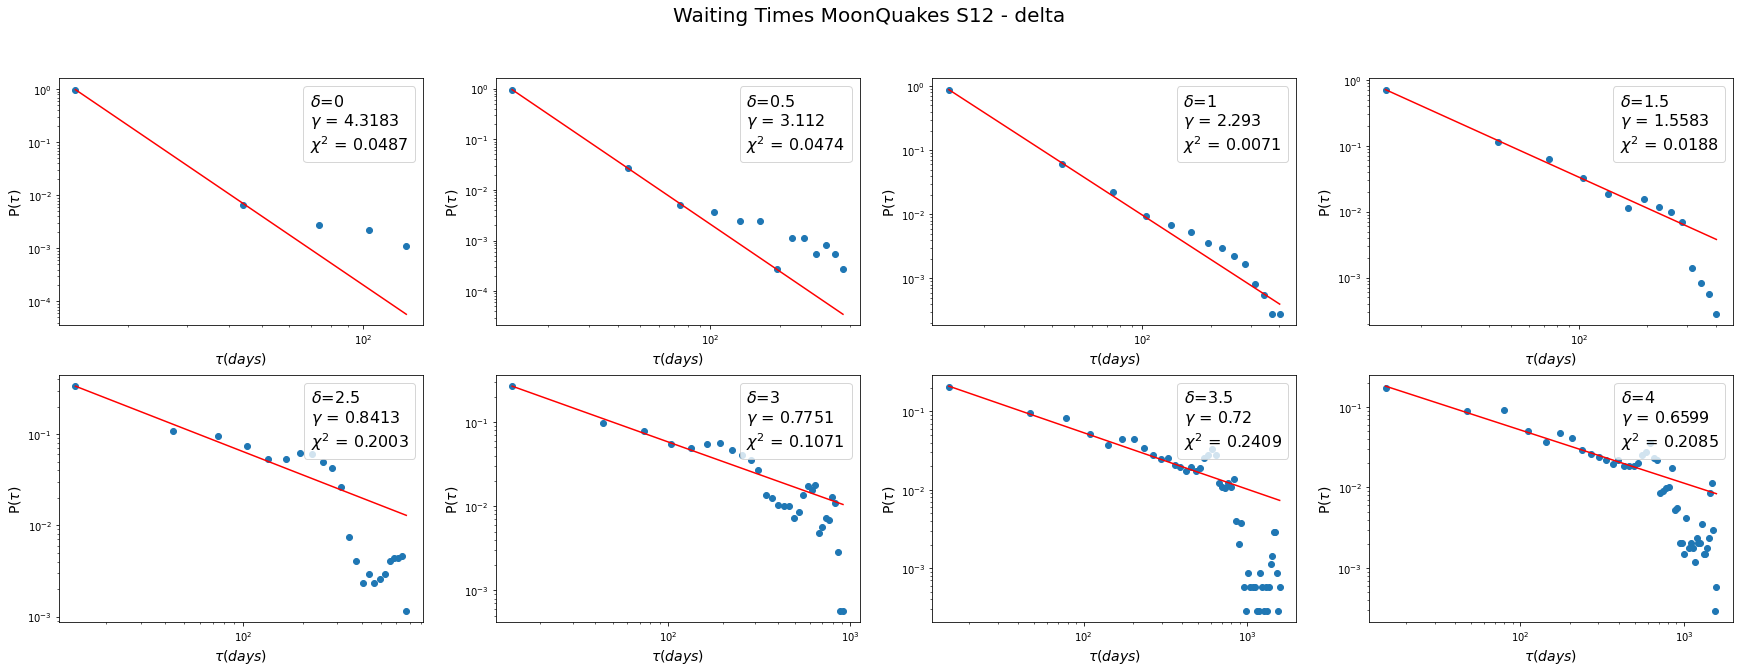

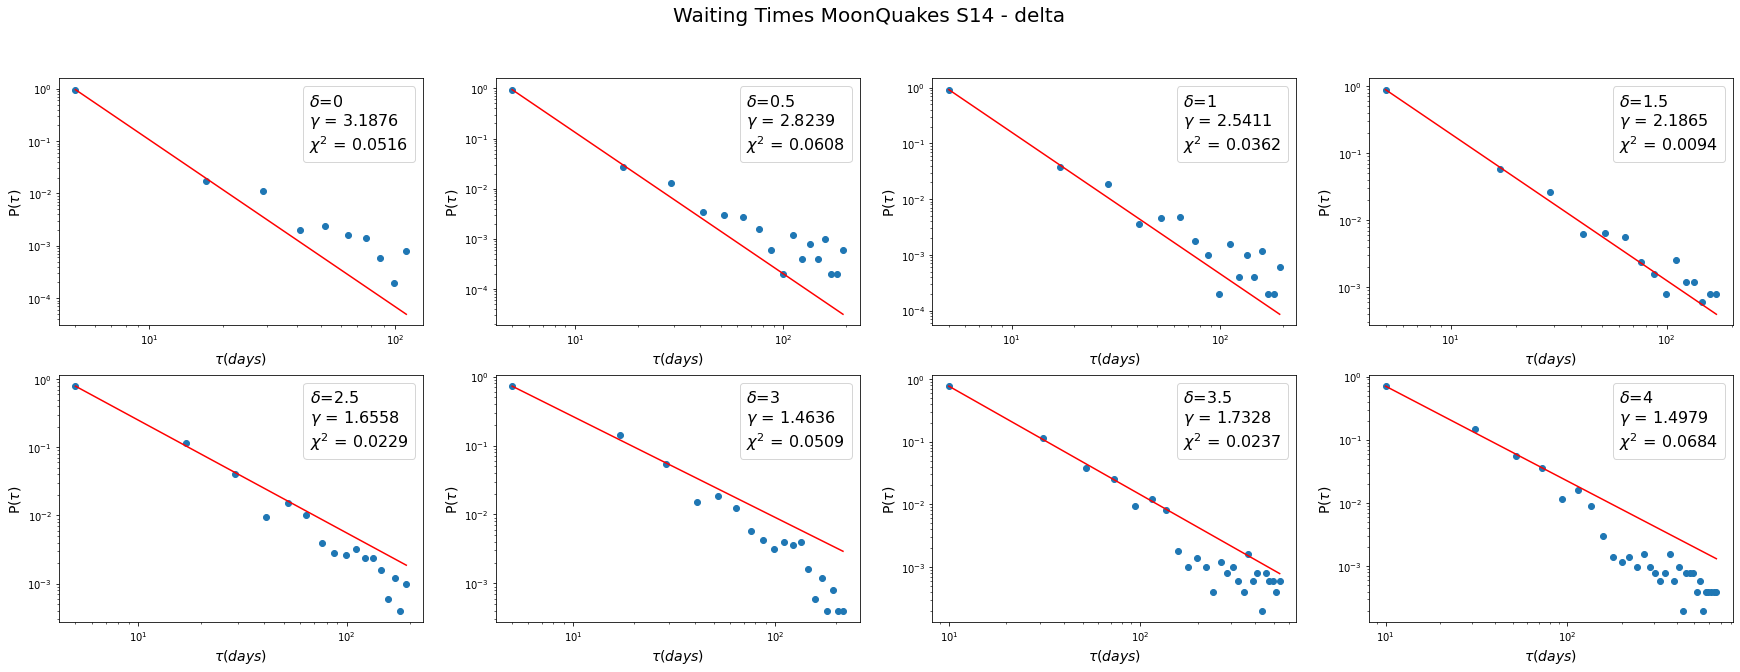

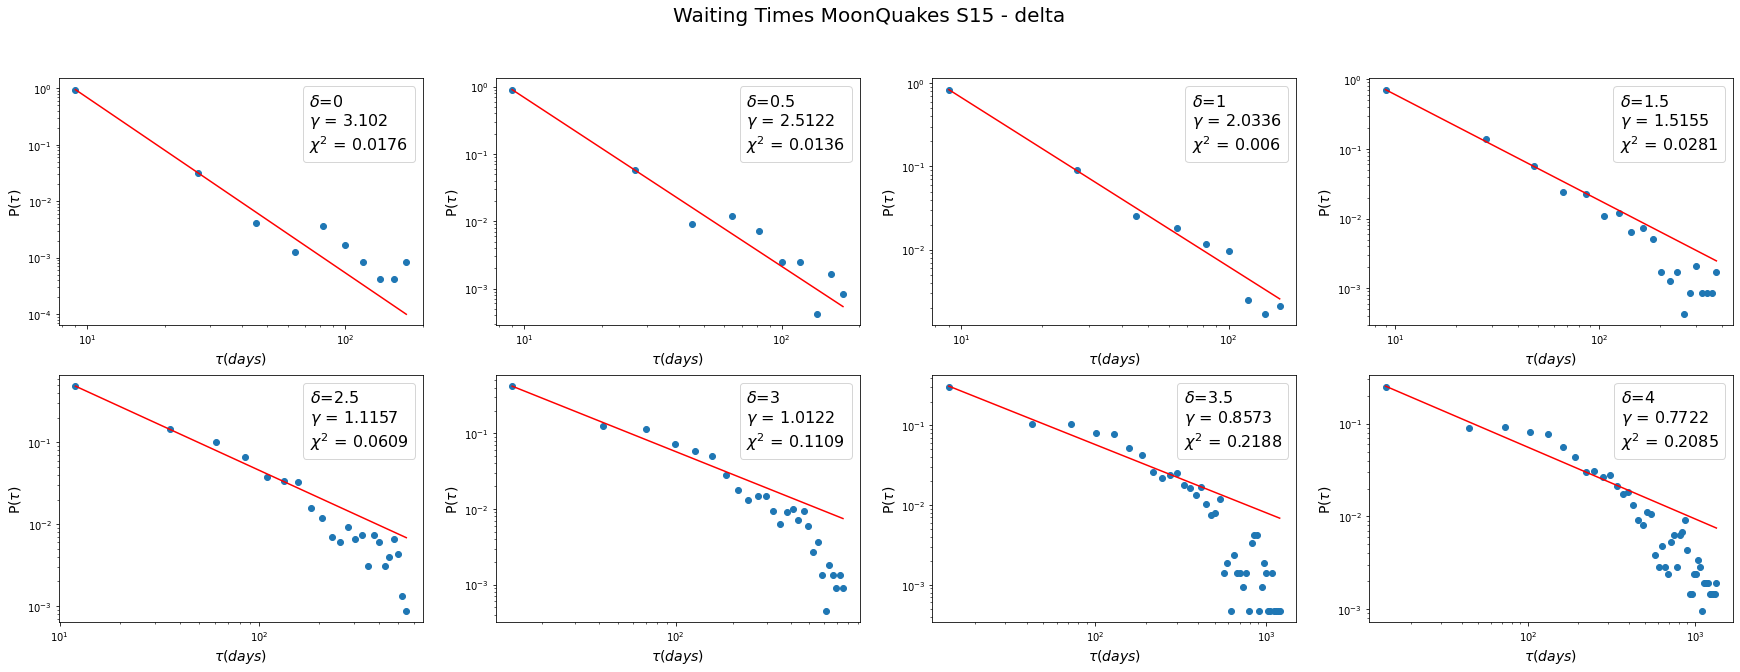

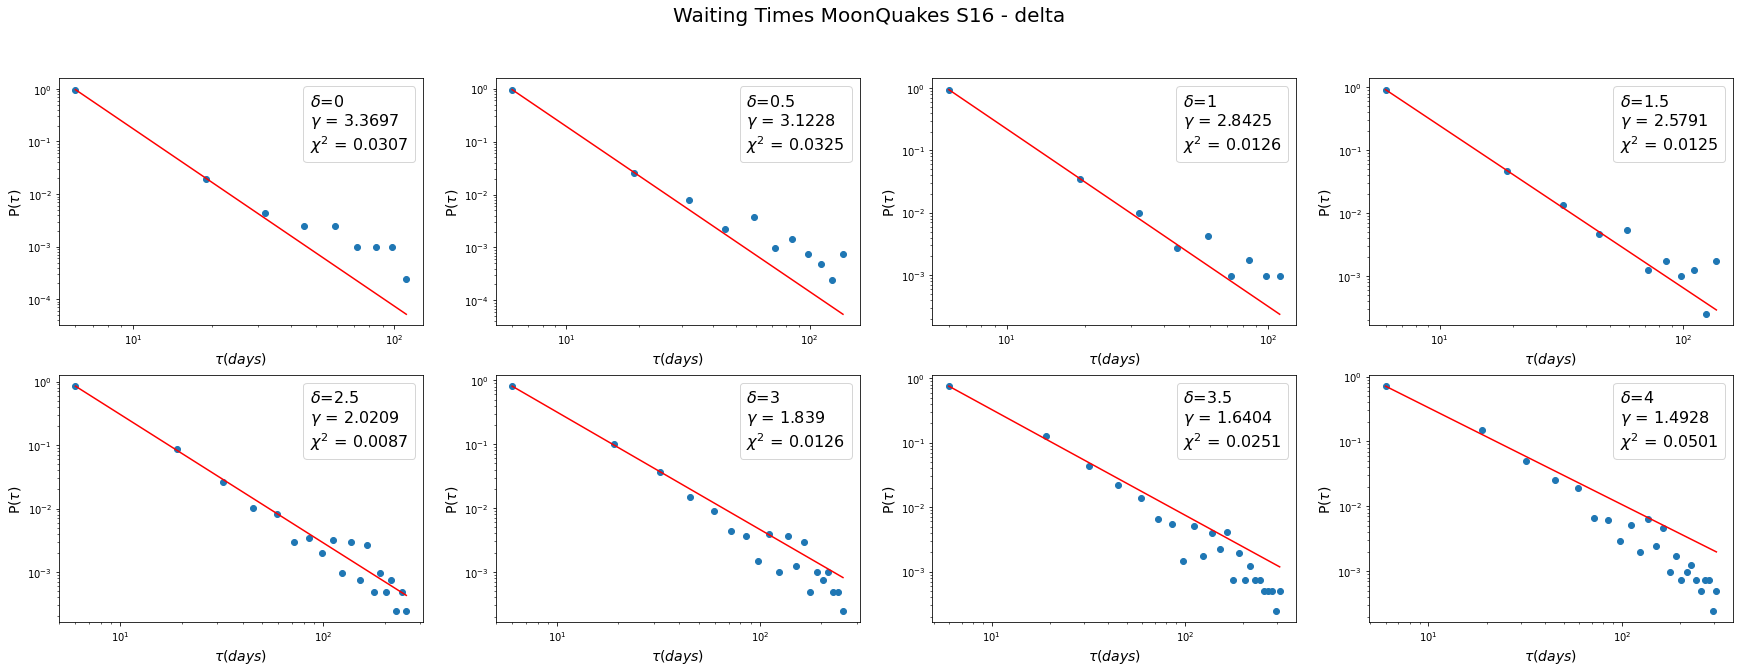

In [8]:
for station in stations:
    quakes = pd.DataFrame({'times':pd.to_datetime(times[station]), 'amplitude': genericAmplitudes[station]})
    
    fig, ax = plt.subplots(2, 4, figsize=(30,10))#, sharex=True, sharey=True)

    ax = np.ravel(ax)
    delta =[0, 0.5, 1, 1.5, 2.5, 3, 3.5, 4]

    for k in range(len(delta)):
        wtid = []

        for i in range(len(quakes['amplitude'])):
            if quakes['amplitude'][i]<max(quakes['amplitude'])-delta[k]:
                firstEvent = quakes['times'][i]

                for j in range(i+1,len(quakes['amplitude'])):
                    if quakes['amplitude'][j]>=quakes['amplitude'][i]+delta[k]:
                        secondEvent = quakes['times'][j]
                        wtid.append((secondEvent-firstEvent).days)
                        break;

        #wtid = waitingTimes2(quakes, delta[i])
        #ax[k].hist(wtid, bins=round(math.sqrt(len(wtid))),density=True)

        # Regressions 

        hist,bins = np.histogram(wtid, bins=round(math.sqrt(len(wtid))))
        # Create the data x,y from the hist and bins
        # x = bins centers . First create empty array of the length of hist
        x = np.zeros_like(hist)
        # Append to it the centers of the bins
        for i in range(1,len(bins)):
            x[i-1]=((bins[i]+bins[i-1])/2)

        # Check for zeros in the hist list and cut both x and y where the first zero occurs
        for i in range(len(hist)):
            if hist[i]==0:
                y=np.array(hist[:i])
                x=np.array(x[:i])
                break
            # If there is no zeros, make y=hist ( full data is taken into acoount)
            else:
                y=hist

        # Renormalize the ydata to 1 
        y_norm = [float(i)/sum(y) for i in y]


        # Compute the power_law fit to our data 
        pars, cov = curve_fit(f=power_law,xdata=x,ydata=y_norm,maxfev=5000)
        # Compute the chi_squared goodness of fit = sum( ( observed - expected )^2 / expected )
        chi_squared = np.sum((y_norm-power_law(x,*pars))**2/power_law(x,*pars))


        # Connectivity distribution ( data + fit)
        # The data, scattered
        ax[k].scatter(x,y_norm)
        ax[k].set_xscale('log')
        ax[k].set_yscale('log')
        # The fit
        ax[k].plot(x,power_law(x,*pars),
                   label=f'$\delta$={delta[k]}\n$\gamma$ = {np.round(pars[1],4)}\n$\chi^2$ = {np.round(chi_squared,4)}',
                   color='red')

        # Legend : gamma coefficient of fit and chi_squared goodness of fit
        ax[k].legend(handlelength=0, handletextpad=0,loc='upper right',fontsize=16,frameon=True)

        # Title of connectivity distribution ( data + fit )
        ax[k].set_xlabel(r'$\tau(days)$', fontsize=16)
        ax[k].set_ylabel(r'P($\tau$)', fontsize=16);

        ax[k].set_xscale('log')
        ax[k].set_yscale('log')
        ax[k].set_xlabel(r'$\tau(days)$', fontsize=14)
        ax[k].set_ylabel(r'P($\tau$)', fontsize=14)


    plt.suptitle(f'Waiting Times MoonQuakes {station} - delta',fontsize=20)
    plt.savefig(f"waitingTimesMoon_{station}.png")

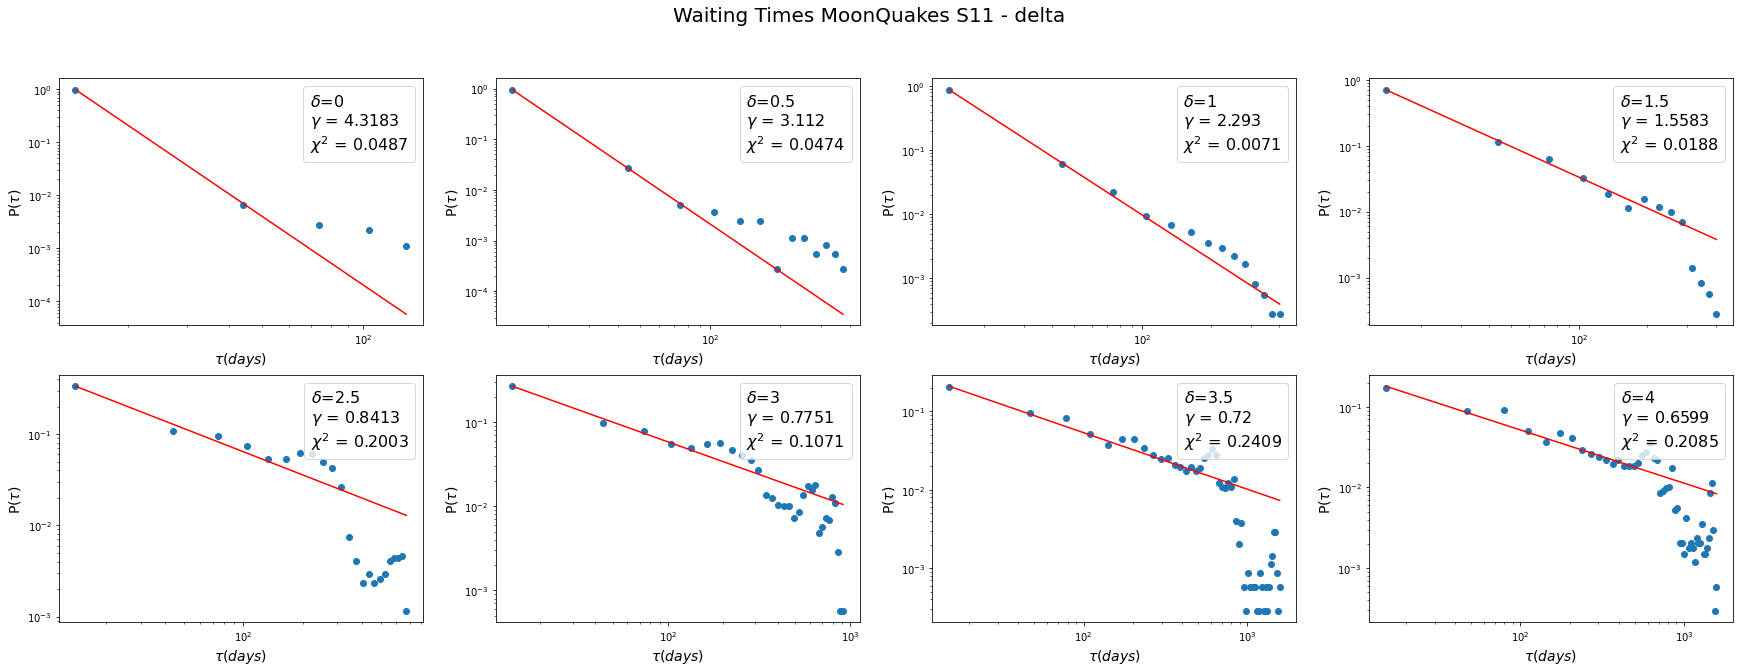

In [80]:
fig, ax = plt.subplots(2, 4, figsize=(30,10))#, sharex=True, sharey=True)

ax = np.ravel(ax)
delta =[0, 0.5, 1, 1.5, 2.5, 3, 3.5, 4]

for k in range(len(delta)):
    wtid = []
    
    for i in range(len(quakes['amplitude'])):
        if quakes['amplitude'][i]<max(quakes['amplitude'])-delta[k]:
            firstEvent = quakes['times'][i]

            for j in range(i+1,len(quakes['amplitude'])):
                if quakes['amplitude'][j]>=quakes['amplitude'][i]+delta[k]:
                    secondEvent = quakes['times'][j]
                    wtid.append((secondEvent-firstEvent).days)
                    break;

    #wtid = waitingTimes2(quakes, delta[i])
    #ax[k].hist(wtid, bins=round(math.sqrt(len(wtid))),density=True)
    
    # Regressions 
    
    hist,bins = np.histogram(wtid, bins=round(math.sqrt(len(wtid))))
    # Create the data x,y from the hist and bins
    # x = bins centers . First create empty array of the length of hist
    x = np.zeros_like(hist)
    # Append to it the centers of the bins
    for i in range(1,len(bins)):
        x[i-1]=((bins[i]+bins[i-1])/2)

    # Check for zeros in the hist list and cut both x and y where the first zero occurs
    for i in range(len(hist)):
        if hist[i]==0:
            y=np.array(hist[:i])
            x=np.array(x[:i])
            break
        # If there is no zeros, make y=hist ( full data is taken into acoount)
        else:
            y=hist

    # Renormalize the ydata to 1 
    y_norm = [float(i)/sum(y) for i in y]

    
    # Compute the power_law fit to our data 
    pars, cov = curve_fit(f=power_law,xdata=x,ydata=y_norm,maxfev=5000)
    # Compute the chi_squared goodness of fit = sum( ( observed - expected )^2 / expected )
    chi_squared = np.sum((y_norm-power_law(x,*pars))**2/power_law(x,*pars))
    
    
    # Connectivity distribution ( data + fit)
    # The data, scattered
    ax[k].scatter(x,y_norm)
    ax[k].set_xscale('log')
    ax[k].set_yscale('log')
    # The fit
    ax[k].plot(x,power_law(x,*pars),
               label=f'$\delta$={delta[k]}\n$\gamma$ = {np.round(pars[1],4)}\n$\chi^2$ = {np.round(chi_squared,4)}',
               color='red')
    
    # Legend : gamma coefficient of fit and chi_squared goodness of fit
    ax[k].legend(handlelength=0, handletextpad=0,loc='upper right',fontsize=16,frameon=True)

    # Title of connectivity distribution ( data + fit )
    ax[k].set_xlabel(r'$\tau(days)$', fontsize=16)
    ax[k].set_ylabel(r'P($\tau$)', fontsize=16);
    
    ax[k].set_xscale('log')
    ax[k].set_yscale('log')
    ax[k].set_xlabel(r'$\tau(days)$', fontsize=14)
    ax[k].set_ylabel(r'P($\tau$)', fontsize=14)


plt.suptitle('Waiting Times MoonQuakes S11 - delta',fontsize=20)
plt.savefig("waitingTimesMoonS11.png")

<ipython-input-9-903fe8ac08b0>:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


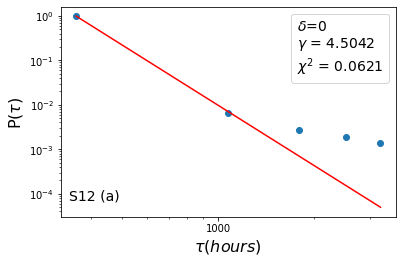

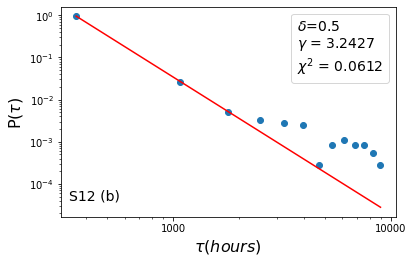

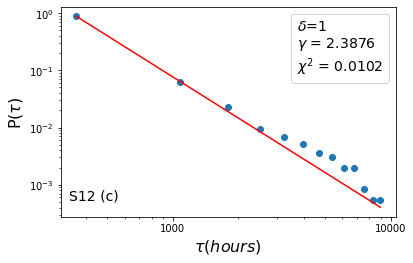

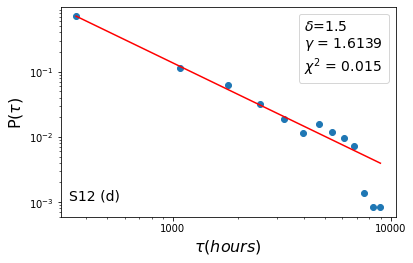

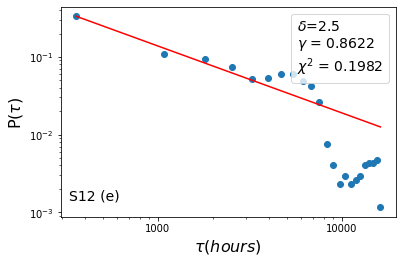

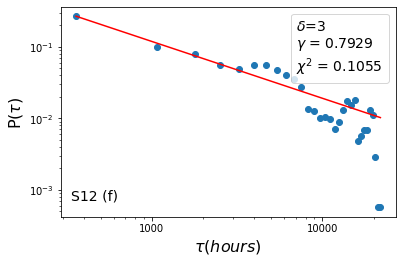

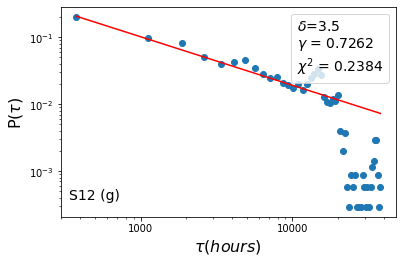

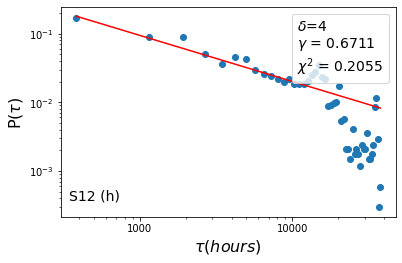

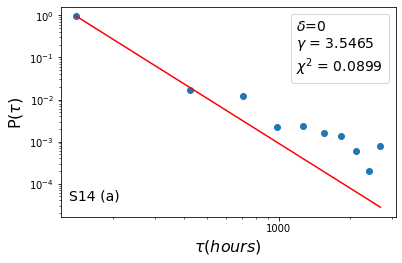

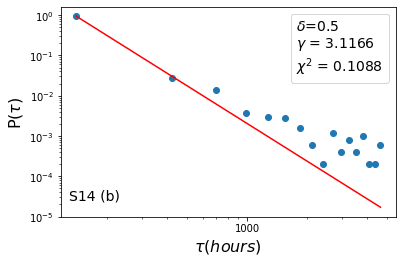

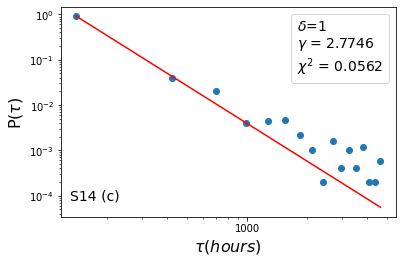

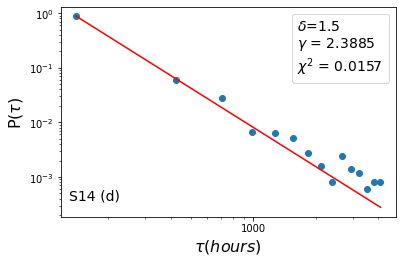

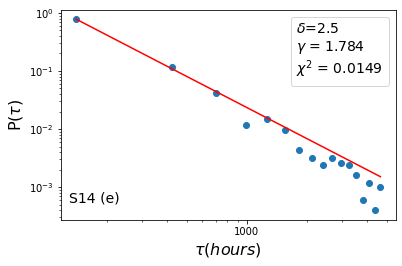

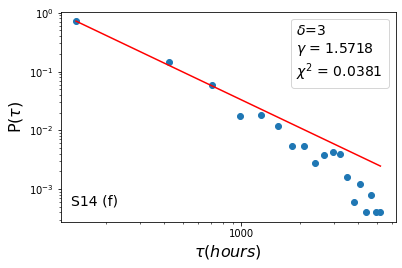

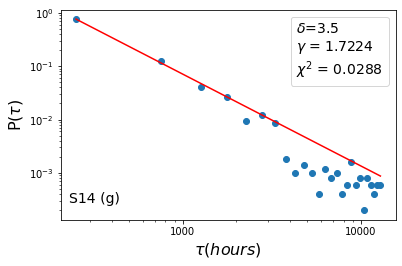

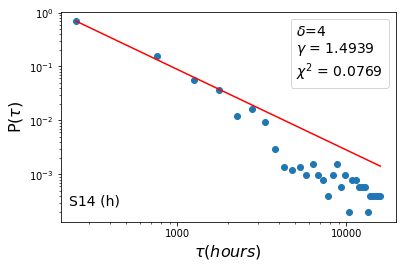

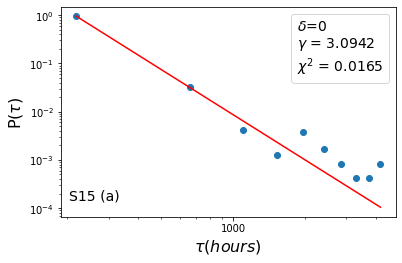

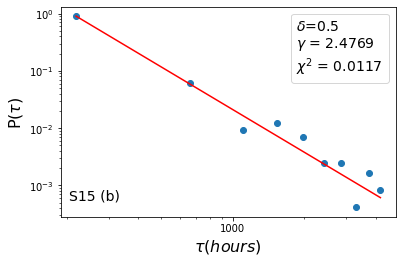

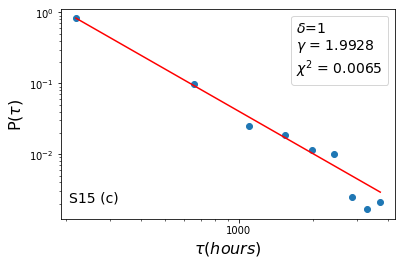

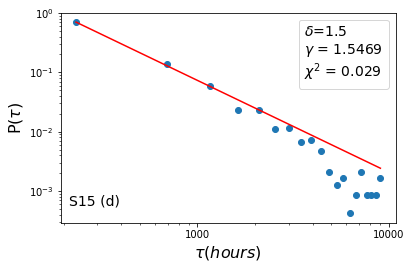

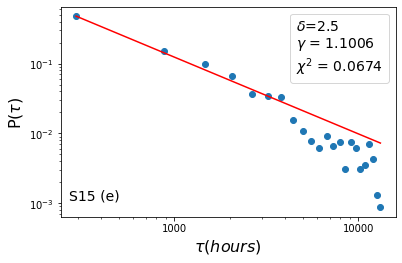

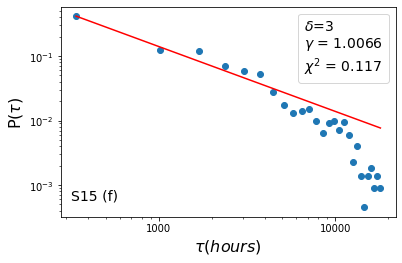

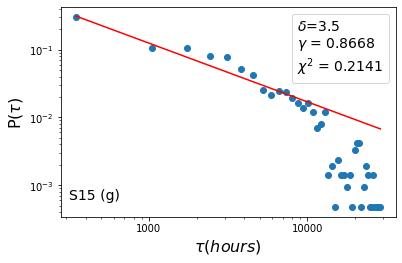

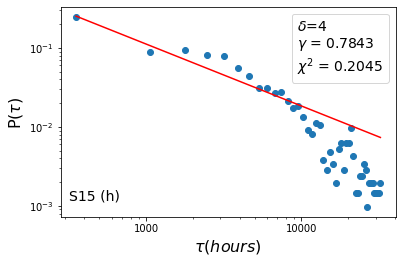

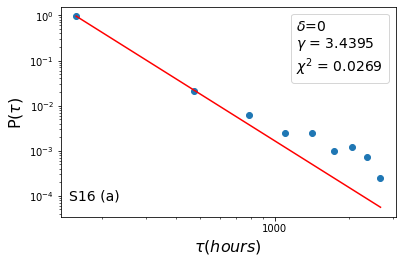

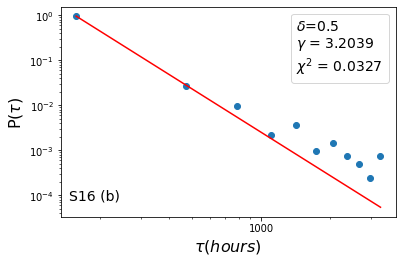

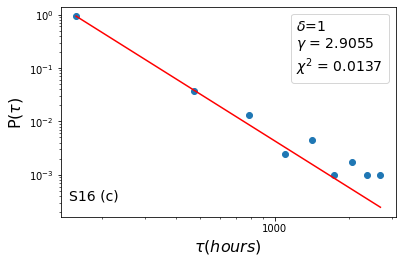

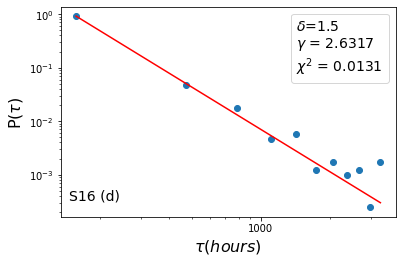

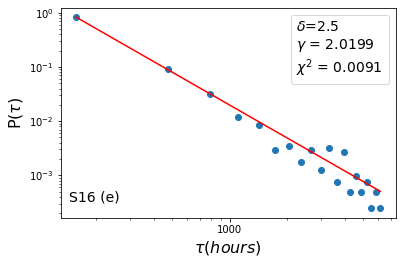

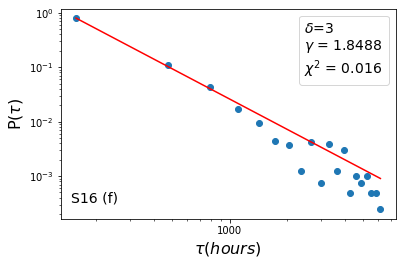

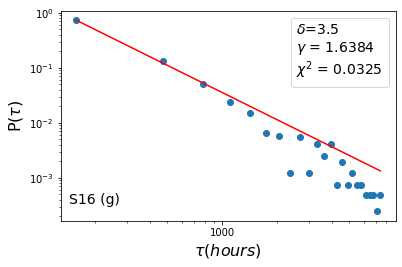

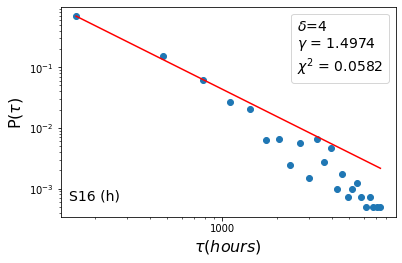

In [9]:
for station in stations:
    quakes = pd.DataFrame({'times':pd.to_datetime(times[station]), 'amplitude': genericAmplitudes[station]})
    
    delta = [0, 0.5, 1, 1.5, 2.5, 3, 3.5, 4]
    labelss = ['a','b','c','d','e','f','g','h']

    for k in range(len(delta)):
        wtid = []

        for i in range(len(quakes['amplitude'])):
            if quakes['amplitude'][i]<max(quakes['amplitude'])-delta[k]:
                firstEvent = quakes['times'][i]

                for j in range(i+1,len(quakes['amplitude'])):
                    if quakes['amplitude'][j]>=quakes['amplitude'][i]+delta[k]:
                        secondEvent = quakes['times'][j]
                        wtid.append(timedelta.Timedelta(secondEvent-firstEvent).total.hours)
                        break;

        hist,bins = np.histogram(wtid, bins=round(math.sqrt(len(wtid))))
        # Create the data x,y from the hist and bins
        # x = bins centers . First create empty array of the length of hist
        x = np.zeros_like(hist)
        # Append to it the centers of the bins
        for i in range(1,len(bins)):
            x[i-1]=((bins[i]+bins[i-1])/2)

        # Check for zeros in the hist list and cut both x and y where the first zero occurs
        for i in range(len(hist)):
            if hist[i]==0:
                y=np.array(hist[:i])
                x=np.array(x[:i])
                break
            # If there is no zeros, make y=hist ( full data is taken into acoount)
            else:
                y=hist

        # Renormalize the ydata to 1 
        y_norm = [float(i)/sum(y) for i in y]


        # Compute the power_law fit to our data 
        pars, cov = curve_fit(f=power_law,xdata=x,ydata=y_norm,maxfev=5000)
        # Compute the chi_squared goodness of fit = sum( ( observed - expected )^2 / expected )
        chi_squared = np.sum((y_norm-power_law(x,*pars))**2/power_law(x,*pars))

        # Connectivity distribution ( data + fit)
        fig = plt.figure()
        ax = fig.add_subplot()

        # The data, scattered
        ax.scatter(x,y_norm)
        ax.set_xscale('log')
        ax.set_yscale('log')

        # The fit
        ax.plot(x,power_law(x,*pars),
                   label=f'$\delta$={delta[k]}\n$\gamma$ = {np.round(pars[1],4)}\n$\chi^2$ = {np.round(chi_squared,4)}',
                   color='red')

        # Legend : gamma coefficient of fit and chi_squared goodness of fit
        ax.legend(handlelength=0, handletextpad=0,loc='upper right',fontsize=14,frameon=True)

        #plt.text(0.5,0.5,f'{labelss[k]}',fontsize=14)
        ax.text(0.1, 0.1, f'{station} ({labelss[k]})',fontsize=14, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

        # Title of connectivity distribution ( data + fit )
        ax.set_xlabel(r'$\tau(hours)$', fontsize=16)
        ax.set_ylabel(r'P($\tau$)', fontsize=16);

        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

        #ax[k].set_xscale('log')
        #ax[k].set_yscale('log')
        #ax[k].set_xlabel(r'$\tau(days)$', fontsize=14)
        #ax[k].set_ylabel(r'P($\tau$)', fontsize=14)
        plt.gcf().subplots_adjust(bottom=0.15)

        plt.savefig(f'waitingTimes_moonDeltas_{station}{labelss[k]}.png')


[    0.         315.453125   630.90625    946.359375  1261.8125
  1577.265625  1892.71875   2208.171875  2523.625     2839.078125
  3154.53125   3469.984375  3785.4375    4100.890625  4416.34375
  4731.796875  5047.25      5362.703125  5678.15625   5993.609375
  6309.0625    6624.515625  6939.96875   7255.421875  7570.875
  7886.328125  8201.78125   8517.234375  8832.6875    9148.140625
  9463.59375   9779.046875 10094.5      10409.953125 10725.40625
 11040.859375 11356.3125   11671.765625 11987.21875  12302.671875
 12618.125    12933.578125 13249.03125  13564.484375 13879.9375
 14195.390625 14510.84375  14826.296875 15141.75     15457.203125
 15772.65625  16088.109375 16403.5625   16719.015625 17034.46875
 17349.921875 17665.375    17980.828125 18296.28125  18611.734375
 18927.1875   19242.640625 19558.09375  19873.546875 20189.      ]


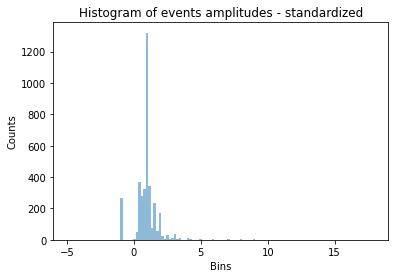

[-1.         -0.81012658 -0.62025316 -0.43037975 -0.24050633 -0.05063291
  0.13924051  0.32911392  0.51898734  0.70886076  0.89873418  1.08860759
  1.27848101  1.46835443  1.65822785  1.84810127  2.03797468  2.2278481
  2.41772152  2.60759494  2.79746835  2.98734177  3.17721519  3.36708861
  3.55696203  3.74683544  3.93670886  4.12658228  4.3164557   4.50632911
  4.69620253  4.88607595  5.07594937  5.26582278  5.4556962   5.64556962
  5.83544304  6.02531646  6.21518987  6.40506329  6.59493671  6.78481013
  6.97468354  7.16455696  7.35443038  7.5443038   7.73417722  7.92405063
  8.11392405  8.30379747  8.49367089  8.6835443   8.87341772  9.06329114
  9.25316456  9.44303797  9.63291139  9.82278481 10.01265823 10.20253165
 10.39240506 10.58227848 10.7721519  10.96202532 11.15189873 11.34177215
 11.53164557 11.72151899 11.91139241 12.10126582 12.29113924 12.48101266
 12.67088608 12.86075949 13.05063291 13.24050633 13.43037975 13.62025316
 13.81012658 14.        ]


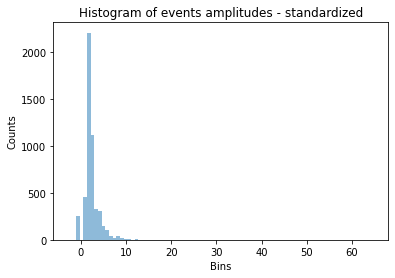

[-1.         -0.18987342  0.62025316  1.43037975  2.24050633  3.05063291
  3.86075949  4.67088608  5.48101266  6.29113924  7.10126582  7.91139241
  8.72151899  9.53164557 10.34177215 11.15189873 11.96202532 12.7721519
 13.58227848 14.39240506 15.20253165 16.01265823 16.82278481 17.63291139
 18.44303797 19.25316456 20.06329114 20.87341772 21.6835443  22.49367089
 23.30379747 24.11392405 24.92405063 25.73417722 26.5443038  27.35443038
 28.16455696 28.97468354 29.78481013 30.59493671 31.40506329 32.21518987
 33.02531646 33.83544304 34.64556962 35.4556962  36.26582278 37.07594937
 37.88607595 38.69620253 39.50632911 40.3164557  41.12658228 41.93670886
 42.74683544 43.55696203 44.36708861 45.17721519 45.98734177 46.79746835
 47.60759494 48.41772152 49.2278481  50.03797468 50.84810127 51.65822785
 52.46835443 53.27848101 54.08860759 54.89873418 55.70886076 56.51898734
 57.32911392 58.13924051 58.94936709 59.75949367 60.56962025 61.37974684
 62.18987342 63.        ]


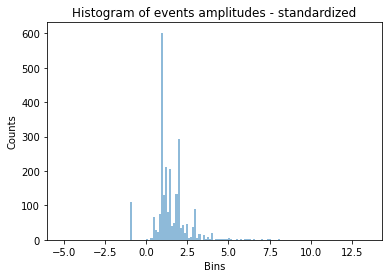

[-1.         -0.87341772 -0.74683544 -0.62025316 -0.49367089 -0.36708861
 -0.24050633 -0.11392405  0.01265823  0.13924051  0.26582278  0.39240506
  0.51898734  0.64556962  0.7721519   0.89873418  1.02531646  1.15189873
  1.27848101  1.40506329  1.53164557  1.65822785  1.78481013  1.91139241
  2.03797468  2.16455696  2.29113924  2.41772152  2.5443038   2.67088608
  2.79746835  2.92405063  3.05063291  3.17721519  3.30379747  3.43037975
  3.55696203  3.6835443   3.81012658  3.93670886  4.06329114  4.18987342
  4.3164557   4.44303797  4.56962025  4.69620253  4.82278481  4.94936709
  5.07594937  5.20253165  5.32911392  5.4556962   5.58227848  5.70886076
  5.83544304  5.96202532  6.08860759  6.21518987  6.34177215  6.46835443
  6.59493671  6.72151899  6.84810127  6.97468354  7.10126582  7.2278481
  7.35443038  7.48101266  7.60759494  7.73417722  7.86075949  7.98734177
  8.11392405  8.24050633  8.36708861  8.49367089  8.62025316  8.74683544
  8.87341772  9.        ]


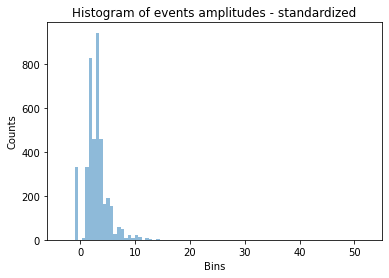

In [10]:
for station in stations:
    data = genericAmplitudes[station]
    print(bins)
    #print(type(bins))
    bins = np.linspace(math.ceil(min(data)), 
                       math.floor(max(data)),
                       80) # fixed number of bins

    plt.xlim([min(data)-5, max(data)+5])

    plt.hist(data, bins=bins, alpha=0.5)
    plt.title('Histogram of events amplitudes - standardized')
    plt.xlabel('Bins')
    plt.ylabel('Counts')

    plt.savefig(f'histogram_amplitudes_{station}.png');
    plt.show()